In [2]:
using InteractiveUtils, Pkg, Revise
using AdvancedHMC; Pkg.activate(pkgdir(AdvancedHMC) * "/research/tests"); Pkg.instantiate()
versioninfo(); Pkg.status()


  Activating project at `~/.julia/dev/AdvancedHMC/research/tests`


Julia Version 1.9.0-rc2
Commit 72aec423c2a (2023-04-01 10:41 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin21.4.0)
  CPU: 20 × Apple M1 Ultra
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, westmere)
  Threads: 2 on 20 virtual cores
Status `~/.julia/dev/AdvancedHMC/research/tests/Project.toml`
  [c75e803d] AdaptiveRejectionSampling v0.1.1
  [0bf59076] AdvancedHMC v0.4.5
  [6e4b80f9] BenchmarkTools v1.3.2
  [863f3e99] Comonicon v1.0.4
  [163ba53b] DiffResults v1.1.0
  [31c24e10] Distributions v0.25.87
  [366bfd00] DynamicPPL v0.22.2
  [6a86dc24] FiniteDiff v2.19.0
  [f6369f11] ForwardDiff v0.10.35
  [7073ff75] IJulia v1.24.0
  [6d524b87] MCMCDebugging v0.2.1 `https://github.com/TuringLang/MCMCDebugging.jl#master`
  [91a5bcdd] Plots v1.38.9
  [d330b81b] PyPlot v2.11.1
  [e0db7c4e] ReTest v0.3.2
  [37e2e3b7] ReverseDiff v1.14.4
  [a8a75453] StatProfilerHTML v1.5.0
  [8a639fad] VecTargets v0.2.0 `https://github.com/xukai92/VecTargets.jl#main`


In [3]:
using Statistics, AdvancedHMC

includet("../src/riemannian_hmc.jl")
includet("../src/riemannian_hmc_utility.jl")

┌ Warning: skipping callee #step#12 (called by step) due to UndefRefError()
└ @ LoweredCodeUtils ~/.julia/packages/LoweredCodeUtils/30gbF/src/signatures.jl:292


Neal's funnel

Progress: 100%|█████████████████████████████████████████| Time: 0:02:59


194.402690 seconds (3.05 G allocations: 111.140 GiB, 10.87% gc time, 17.07% compilation time)
Quantile error: 0.004290000000000003


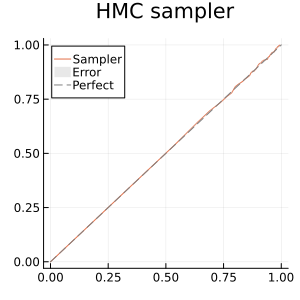

In [4]:
using Distributions, DynamicPPL

# Treating the first 2 dimensions as latent and the third as data.
@model function TuringFunnel(θ=missing, x=missing)
    if ismissing(θ)
        θ = Vector(undef, 2)
    end
    θ[1] ~ Normal(0, 3)
    s = exp(θ[1] / 2)
    θ[2] ~ Normal(0, s)
    x ~ Normal(0, s)
    return θ, x
end

# Sanity check for normal HMC
function rand_θ_given_hmc(target, hps, x_data; seed=rand(UInt32))
    rng = MersenneTwister(seed)
    
    D = dim(target) - 1
    θ₀ = rand(rng, D)
    
    ℓπ = x -> logpdf(target, vcat(x, x_data))
    ∂ℓπ∂θ = VecTargets.gen_grad(ℓπ, θ₀)

    metric = DenseEuclideanMetric(D)
    kinetic = GaussianKinetic()
    hamiltonian = Hamiltonian(metric, kinetic, ℓπ, ∂ℓπ∂θ)

    TS = EndPointTS
    
    integrator = GeneralizedLeapfrog(hps.ϵ, hps.n)

    tc = FixedNSteps(hps.L)
    
    proposal = HMCKernel(Trajectory{TS}(integrator, tc))

    samples, stats = sample(
        rng, hamiltonian, proposal, θ₀, hps.n_samples; progress=false, verbose=true
    )
    
    return samples[end]
end

make_rand_θ_given_hmc(hps, target) = x -> rand_θ_given_hmc(hps, target, x)

g(θ, x) = cat(θ, x; dims=1)

using MCMCDebugging
using Logging: NullLogger, with_logger

hps_geweke = (; n_samples=100, λ=1e-2, α=20.0, ϵ=0.1, n=6, L=8)

@time res = with_logger(NullLogger()) do
    perform(GewekeTest(1000), TuringFunnel, make_rand_θ_given_hmc(Funnel(3), hps_geweke); g=g)
end

using Plots: Plots

Plots.plot(res, TuringFunnel(); size=(300, 300), title="HMC sampler")

In [5]:
# I still need to use the hand-written one because of AD
function rand_θ_given(hps, target, x_data; seed=rand(UInt32))
    rng = MersenneTwister(seed)
    
    D = dim(target) - 1
    θ₀ = rand(rng, D)
    
    ℓπ = x -> logpdf(target, vcat(x, x_data))
    ∂ℓπ∂θ = VecTargets.gen_grad(ℓπ, θ₀)
    
    _, _, Gfunc, ∂G∂θfunc = prepare_sample_target(hps, θ₀, ℓπ)

    metric = DenseRiemannianMetric((D,), Gfunc, ∂G∂θfunc, SoftAbsMap(hps.α))
    kinetic = GaussianKinetic()
    hamiltonian = Hamiltonian(metric, kinetic, ℓπ, ∂ℓπ∂θ)

    TS = EndPointTS
    
    integrator = GeneralizedLeapfrog(hps.ϵ, hps.n)

    tc = FixedNSteps(hps.L)
    
    proposal = HMCKernel(Trajectory{TS}(integrator, tc))

    samples, stats = sample(
        rng, hamiltonian, proposal, θ₀, hps.n_samples; progress=false, verbose=true
    )
    
    return samples[end]
end

make_rand_θ_given(hps, target) = x -> rand_θ_given(hps, target, x)

hps_geweke = (; n_samples=100, λ=1e-2, α=20.0, ϵ=0.1, n=6, L=8)

@time res_1 = with_logger(NullLogger()) do 
    perform(GewekeTest(1000), TuringFunnel, make_rand_θ_given(hps_geweke, Funnel(3)); g=g)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:09:11


551.463349 seconds (2.11 G allocations: 114.917 GiB, 5.26% gc time, 4.67% compilation time)


Geweke (Joint Distribution) Test
--------------------------------
Results:
    Number of samples: 1000
    Parameter dimension: 2
    Data dimension: 1
    Statistic: [3.282291974169936, -0.21347102158228864, -0.9142852605863748]
    P-value: [0.00102966928376445, 0.8309595896158011, 0.360566973434177]


┌ Warning: skipping callee #step#88 (called by step) due to UndefRefError()
└ @ LoweredCodeUtils ~/.julia/packages/LoweredCodeUtils/30gbF/src/signatures.jl:292


Quantile error: 0.01914


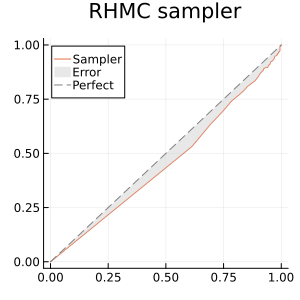

In [6]:
Plots.plot(res_1, TuringFunnel(); size=(300, 300), title="RHMC sampler")

In [7]:
hps_geweke = (; hps_geweke..., n=12)

@time res_2 = with_logger(NullLogger()) do 
    perform(GewekeTest(1000), TuringFunnel, make_rand_θ_given(hps_geweke, Funnel(3)); g=g)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:12:31


752.012771 seconds (2.55 G allocations: 143.352 GiB, 5.57% gc time, 0.00% compilation time)


Geweke (Joint Distribution) Test
--------------------------------
Results:
    Number of samples: 1000
    Parameter dimension: 2
    Data dimension: 1
    Statistic: [-2.3200821445881115, 0.9179149195872197, -0.1682369201106771]
    P-value: [0.020336434050855494, 0.3586634100857047, 0.8663968968171001]


Quantile error: 0.006290000000000003


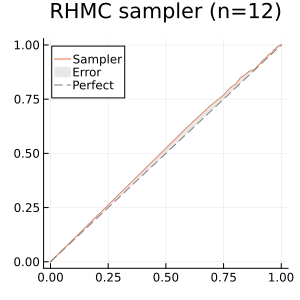

In [8]:
Plots.plot(res_2, TuringFunnel(); size=(300, 300), title="RHMC sampler (n=12)")

A simpler target

Progress: 100%|█████████████████████████████████████████| Time: 0:06:40


400.461602 seconds (7.29 G allocations: 248.938 GiB, 18.78% gc time, 0.22% compilation time)
Quantile error: 0.011189999999999999


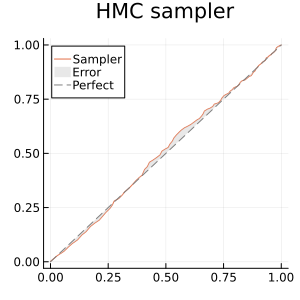

In [9]:
using VecTargets: ContinuousMultivariateDistribution, _logpdf_normal
import VecTargets: dim, logpdf

struct SimpleTarget <: ContinuousMultivariateDistribution end

dim(st::SimpleTarget) = 3

function _logpdf_st(θx::AbstractVecOrMat)
    θ1, θ2, x = θx[1,:], θx[2,:], θx[3,:]
    s = 1

    lp11 = _logpdf_normal(θ1, 0, s) # _logpdf_normal(x, m, s)
    lp12 = _logpdf_normal(θ2, 0, s)
    lp2 = _logpdf_normal(x, θ1, s)
    
    return lp11 + lp12 + lp2
end

logpdf(::SimpleTarget, θ::AbstractVector) = only(_logpdf_st(θ))

logpdf(::SimpleTarget, θ::AbstractMatrix) = _logpdf_st(θ)

# Treating the first 2 dimensions as latent and the third as data.
@model function TuringSimple(θ=missing, x=missing)
    if ismissing(θ)
        θ = Vector(undef, 2)
    end
    θ[1] ~ Normal(0, 1)
    θ[2] ~ Normal(0, 1)
    x ~ Normal(θ[1], 1)
    return θ, x
end

hps_geweke = (; n_samples=100, λ=1e-2, α=20.0, ϵ=0.1, n=6, L=8)

@time res = with_logger(NullLogger()) do
    perform(GewekeTest(1000), TuringSimple, make_rand_θ_given_hmc(SimpleTarget(), hps_geweke); g=g)
end

Plots.plot(res, TuringSimple(); size=(300, 300), title="HMC sampler")

In [10]:
hps_geweke = (; n_samples=100, λ=1e-2, α=20.0, ϵ=0.1, n=6, L=8)

@time res_3 = with_logger(NullLogger()) do 
    perform(GewekeTest(1000), TuringSimple, make_rand_θ_given(hps_geweke, SimpleTarget()); g=g)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:08:08


488.344858 seconds (3.55 G allocations: 145.002 GiB, 10.06% gc time, 2.11% compilation time)


Geweke (Joint Distribution) Test
--------------------------------
Results:
    Number of samples: 1000
    Parameter dimension: 2
    Data dimension: 1
    Statistic: [0.5423269859773646, 0.3360818396809431, 1.4501789475829876]
    P-value: [0.5875932684048804, 0.736809152576956, 0.1470086241673572]


Quantile error: 0.00538


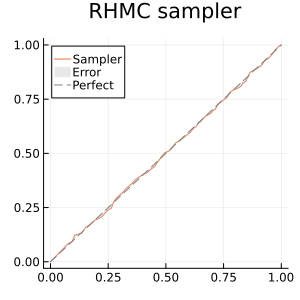

In [11]:
Plots.plot(res_3, TuringSimple(); size=(300, 300), title="RHMC sampler")

In [12]:
hps_geweke = (; hps_geweke..., n=12)

@time res_4 = with_logger(NullLogger()) do 
    perform(GewekeTest(1000), TuringSimple, make_rand_θ_given(hps_geweke, SimpleTarget()); g=g)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:10:44


644.787483 seconds (4.06 G allocations: 170.428 GiB, 9.58% gc time, 0.00% compilation time)


Geweke (Joint Distribution) Test
--------------------------------
Results:
    Number of samples: 1000
    Parameter dimension: 2
    Data dimension: 1
    Statistic: [-0.7894983102391123, 0.36607196147763205, 0.15967734922313906]
    P-value: [0.42982081699651603, 0.714311379039565, 0.8731352446390127]


Quantile error: 0.0027900000000000012


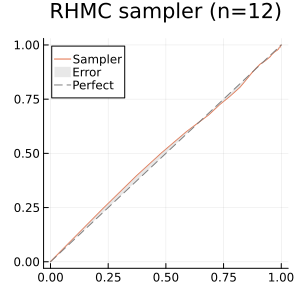

In [13]:
Plots.plot(res_4, TuringFunnel(); size=(300, 300), title="RHMC sampler (n=12)")